In [111]:
import ipywidgets as widgets
import skrf as rf
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

from skrf.media import Coaxial

In [112]:
%matplotlib notebook

In [113]:
class Section(widgets.VBox):
    CONDUCTIVITIES = {
        'Steel': 1/69e-8, # 1.45e6 in Wikipedia
        'Copper': 1/1.682e-8, # 5.8e7 # Annealed copper.  5.96e7 for pure Cu in Wikipedia
        'Copper_200deg': 34578645,  # Copper 200deg 
        'Silver': 1/1.59e-8, #6.3e7 # Wikipedia
        'Aluminium': 1/2.65e-8, #3.8e7 # Wikipedia
    }
        
    def __init__(self, kind: str = 'Line', config: dict = None):
        '''
        Section object
        
        Parameters
        ----------
        kind : str
            'Line', 'Short' or 'Tee'
        config : dict
            Dictionnary containing the Section properties (optional)
            Keys are 'Dint', 'Dout', 'L', 'R' and 'sigma'
        '''
        width = '180px'
        self.kind = kind

        self.w_kind = widgets.Dropdown(
            value=self.kind,
            placeholder='Choose kind',
            options=['Line', 'Short', 'Tee'],
            description='Type',
            disabled=False,
            layout=widgets.Layout(width=width)
        )

        self.output = widgets.Output()

        # define the various widgets
        self.w_Dint = widgets.BoundedIntText(description='Dint', value=140, min=20, max=300, layout=widgets.Layout(width=width))
        self.w_Dout= widgets.BoundedIntText(description='Dout', value=230, min=100, max=400, layout=widgets.Layout(width=width))
        self.w_L = widgets.FloatSlider(description='', min=0, max=10000, step=1, value=100, layout=widgets.Layout(width=width))
        self.w_sigma = widgets.Dropdown(
            value = 'Copper',
            options = ['Copper', 'Silver', 'Aluminium', 'Steel'],
            description = 'Metal',
            disabled = False,
            layout=widgets.Layout(width=width)
        )
        self.w_R = widgets.FloatText(description='R [Ohm]', value=1e-3, layout=widgets.Layout(width=width))

        # set widget properties if passed
        if config:
            for key in config.keys():
                if key == 'Dint':
                    self.w_Dint.value = config[key]
                elif key == 'Dout':
                    self.w_Dout.value = config[key]
                elif key in ('L', 'Lengh'):
                    self.w_L.value = config[key]
                elif key == 'R':
                    self.w_R.value = config[key]
                elif key == 'sigma':
                    self.w_sigma.value = config[key]
        
        super().__init__(children=self.UI, 
                         layout=widgets.Layout(border='solid'))

        self.w_kind.observe(self.__on_kind_change, 'value')

        
    def __on_kind_change(self, change):
        self.kind = change['new']
        self.__instantiate_ui()

    @property
    def UI(self):
        # instantiate the new kind widget 
        if self.kind == 'Line':
            UI = [self.w_kind, self.w_Dint, self.w_Dout, self.w_L, self.w_sigma]
        elif self.kind == 'Short':
            UI = [self.w_kind, self.w_Dint, self.w_Dout, self.w_R]
        elif self.kind == 'Tee':
            UI = [self.w_kind, self.w_Dint, self.w_Dout, self.w_sigma]
        return UI
    
    def __instantiate_ui(self):
        self.children = self.UI
        display(self)

    def to_dict(self):
        '''
        Return a dictionnary version of the Section configuration
        '''
        if self.kind == 'Line':
            return {
                'kind': self.kind,
                'Dint': self.w_Dint.value,
                'Dout': self.w_Dout.value,
                'Length': self.w_L.value,
                'sigma': self.w_sigma.value,
            }
        elif self.kind == 'Short':
            return {
                'kind': self.kind,
                'Dint': self.w_Dint.value,
                'Dout': self.w_Dout.value,
                'R': self.w_R.value
            }
        elif self.kind == 'Tee':
            return {
                'kind': self.kind,
                'Dint': self.w_Dint.value,
                'Dout': self.w_Dout.value,
                'sigma': self.w_sigma.value,
            }

    

    @classmethod
    def sigma_2_value(cls, sigma: str) -> float:
        '''
        Return the electrical conductivity of the given metal
        
        Parameter
        ---------
        sigma: str
            Metal type
        
        Return
        ------
        sigma_value: float
            Electrical Conductivity in S/m
        '''
        try: 
            return cls.CONDUCTIVITIES[sigma]
        except KeyError as e:
            raise ValueError('Uncorrect sigma description')
        
    def to_network(self, frequency):
        '''
        Return the Section scikit-rf Network
        
        Parameters
        ----------
        frequency: skrf.Frequency
            Frequency to evaluate the Network on
        
        Return
        ------
        ntwk: skrf.Network
            Section's resulting Network

        '''
        media = Coaxial(frequency=frequency, 
                        Dint=self.w_Dint.value*1e-3, 
                        Dout=self.w_Dout.value*1e-3, 
                        epsilon_r=1, 
                        sigma=self.sigma_2_value(self.w_sigma.value)
                       )
        
        if self.kind == 'Line':
            return media.line(self.w_L.value, unit='mm', name=f'Line_{self.w_L.value}')
        elif self.kind == 'Tee':
            return media.tee(name='tee')
        elif self.kind == 'Short':
            return media.resistor(self.w_R.value, name=f'Short_R_{self.w_R.value}') ** media.short()
        else:
            raise ValueError('Incorrect kind type: ', self.kind)

In [114]:
Section(config={'Dint': 200, 'L': 2200})

Section(children=(Dropdown(description='Type', layout=Layout(width='180px'), options=('Line', 'Short', 'Tee'),…

In [127]:
class ResonatorBuilder(widgets.VBox):
    def __init__(self):
        # initial configuration
        self._config = [Section('Short'), 
                        Section('Line', config={'L': 2700}), 
                        Section('Tee'), 
                        Section('Line', config={'L': 2750}), 
                        Section('Short')]
        # define + and - buttons
        self.w_add_left = widgets.Button(icon="plus-square", layout=widgets.Layout(width='30px'))
        self.w_add_right = widgets.Button(icon="plus-square", layout=widgets.Layout(width='30px'))
        self.w_del_left = widgets.Button(icon="minus-square", layout=widgets.Layout(width='30px'))
        self.w_del_right = widgets.Button(icon="minus-square", layout=widgets.Layout(width='30px'))
        # define callbacks for + and - buttons
        self.w_add_left.on_click(self.add_section_to_the_left)
        self.w_add_right.on_click(self.add_section_to_the_right)
        self.w_del_left.on_click(self.del_section_to_the_left)
        self.w_del_right.on_click(self.del_section_to_the_right)
        
        self.output = widgets.Output()
        
        self.w_plot = widgets.Button(description='plot')
        self.w_plot.on_click(self.update_plot)
        self.__update_display()
        super().__init__(children=self.UI)
        
        self.fig, self.ax = plt.subplots()
        

    @property
    def UI(self):
        return [
            widgets.HBox([
                widgets.VBox([self.w_add_left, self.w_del_left]), 
                *self.config, 
                widgets.VBox([self.w_add_right, self.w_del_right]),
            ]),
            self.w_plot,
            self.output,
        ]
        
    def add_section_to_the_left(self, change):
        self.config.insert(0, Section())
        self.__update_display()

    def add_section_to_the_right(self, change):
        self.config.append(Section())
        self.__update_display()
            
    def del_section_to_the_left(self, change):
        self.config.pop(0)
        self.__update_display()
            
    def del_section_to_the_right(self, change):
        self.config.pop()
        self.__update_display()
            
    def __update_display(self):
        self.children = self.UI
        # update callback to trigger plot update when one change a widget
        for section in self.config:
            for child in section.children:
                child.observe(self.update_plot)

    @property
    def config(self) -> list:
        '''
        Get the UI configuration 
        '''
        return self._config

    @config.setter
    def config(self, cfg: list):
        '''
        Set the UI configuration
        '''
        self._config = cfg
        
    @property
    def configuration(self) -> list:
        '''
        Returns a simplified version of the configuration 
        '''
        configuration = [section.to_dict() for section in self.config]
        return configuration
    
    def networks_list(self, frequency) -> list:
        '''
        Return the list of Networks which compose the resonator
        
        Parameter
        ---------
        frequency : skrf.Frequency
            Frequency to evaluate the Network on
            
        Return
        ------
        networks: list of skrf.Network
            List of the Networks which compose the resonator
        '''
        networks = [section.to_network(frequency) for section in self.config]
        return networks

    def is_valid(self) -> bool:
        '''
        Check if the resonator configuration is valid
        
        Check if:
            - there is only one Tee
            - there are two Shorts
            - Short are at both ends
            - There is at least two Lines
            
        Return
        ------
        is_valid : bool
            True if the resonator is valid, False otherwise
        '''
        cfg = self.configuration
        is_valid = False
        kinds = []
        for section in cfg:
            kinds.append(section['kind'])
    
        if (kinds.count('Tee') == 1) and (kinds[0] == 'Short') and (kinds[-1] == 'Short') and (kinds.count('Short') == 2) and (kinds.count('Line') >= 2):
            is_valid = True
        
        return is_valid
    
    def to_network(self, frequency):
        '''
        Return the resonator Network for a given frequency
        
        Parameter
        ---------
        frequency : skrf.Frequency
            Frequency to evaluate the Network on
            
        Return
        ------
        network : krf.Network
            Resonator Network        
        '''
        
        if self.is_valid():
            # Calculate all Networks
            networks = self.networks_list(frequency)
                
            # traverse the list until we found the Tee
            for (idx, section) in enumerate(networks):
                if section.name == 'tee':
                    idx_tee = idx
            # split the resonator in two branches
            networks_branch_left = networks[:idx_tee]
            tee = networks[idx_tee]
            networks_branch_right = networks[idx_tee+1:]
            # caccade left and right branches
            branch_left = rf.cascade_list(networks_branch_left[-1::-1])  # cascade in reverse order to keep the short at the end
            branch_right = rf.cascade_list(networks_branch_right)
            # connect the tee
            resonator = rf.connect(rf.connect(branch_left, 0, tee, 1), 1, branch_right, 0)
            
            return resonator
        else:
            raise ValueError('Resonator is not valid. Check its consistency !')
            
    def update_plot(self, change, frequency=rf.Frequency(54, 56, unit='MHz', npoints=301)):
        with self.output:
            plt.clf()  # avoid superposing curves
            ntwk = self.to_network(frequency)
            
            ax=plt.gca()
            ax.plot(ntwk.frequency.f_scaled, ntwk.s_db.squeeze())
            # find min and display
            f_match = ntwk.frequency.f_scaled[np.argmin(ntwk.s_mag)]
            ax.set_title(f'Match Freq: {f_match:0.2f} MHz')
            ax.set_ylim(-30, 1)

<IPython.core.display.Javascript object>


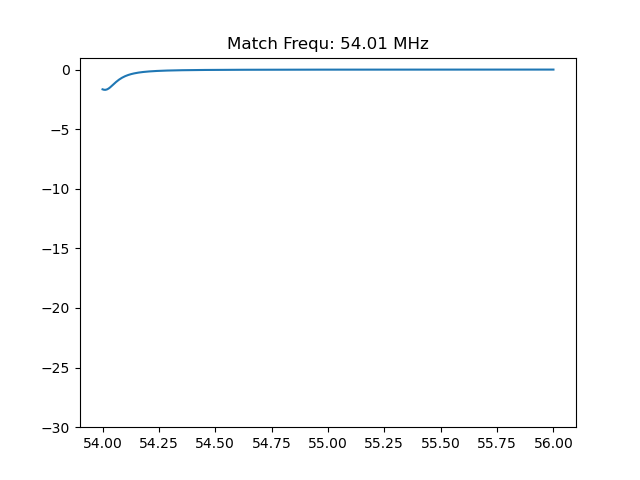

ResonatorBuilder(children=(HBox(children=(VBox(children=(Button(icon='plus-square', layout=Layout(width='30px'…

Section(children=(Dropdown(description='Type', index=1, layout=Layout(width='180px'), options=('Line', 'Short'…

Section(children=(Dropdown(description='Type', layout=Layout(width='180px'), options=('Line', 'Short', 'Tee'),…

In [128]:
rb=ResonatorBuilder()
rb

In [118]:
frequency = rf.Frequency(40, 70, unit='MHz', npoints=101)
rb.to_network(frequency).s_db.squeeze()


array([-4.66263457e-03, -4.57620365e-03, -4.49306167e-03, -4.41313182e-03,
       -4.33633507e-03, -4.26259126e-03, -4.19181948e-03, -4.12393888e-03,
       -4.05886948e-03, -3.99653223e-03, -3.93684968e-03, -3.87974616e-03,
       -3.82514825e-03, -3.77298466e-03, -3.72318696e-03, -3.67568914e-03,
       -3.63042835e-03, -3.58734479e-03, -3.54638181e-03, -3.50748609e-03,
       -3.47060790e-03, -3.43570114e-03, -3.40272381e-03, -3.37163804e-03,
       -3.34241073e-03, -3.31501371e-03, -3.28942473e-03, -3.26562788e-03,
       -3.24361535e-03, -3.22338833e-03, -3.20495933e-03, -3.18835531e-03,
       -3.17362142e-03, -3.16082699e-03, -3.15007395e-03, -3.14150971e-03,
       -3.13534561e-03, -3.13188736e-03, -3.13158224e-03, -3.13509908e-03,
       -3.14346532e-03, -3.15831713e-03, -3.18237902e-03, -3.22045383e-03,
       -3.28164580e-03, -3.38495490e-03, -3.57563776e-03, -3.98467169e-03,
       -5.13456293e-03, -1.10943786e-02, -3.77622353e+00, -1.24871551e-02,
       -5.35955803e-03, -

In [6]:
200+180+2000

2380

In [7]:
200+100+239+1224+200


1963

In [8]:
resonator

NameError: name 'resonator' is not defined